In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# 데이터 전처리

## 1. minmaxscaler / list 형태로 정리

In [2]:
def MinMaxScale(data):
    numerator = data - min(data)
    denominator = max(data) - min(data)
    normalization = numerator / (denominator + 1e-7)
    return normalization

In [23]:
#ipynb 파일과 같은 폴더에 모든 데이터 다운로드하여 사용할 것
#시간
time_list = pd.read_excel('평균수온18-20.xlsx')['시간'].values

#평균수온
label_ = pd.read_excel('평균수온18-20.xlsx')['평균수온(°∆C)'].values
label_norm = MinMaxScale(label_)

#메탄가스, 아산화질소, 염화불화탄소13, 이산화탄소
raw_df_gas = pd.read_excel('온실가스18-20.xlsx') #1096일

dataset_methane = raw_df_gas['평균메탄배경대기농도(ppb)'].values
dataset_methane_norm = MinMaxScale(dataset_methane)

dataset_n2o = raw_df_gas['평균 아산화질소(N2O) 배경대기농도(ppb)'].values
dataset_n2o_norm = MinMaxScale(dataset_n2o)

dataset_cfc13 = raw_df_gas['평균 염화불화탄소113(CFC113) 배경대기농도(ppt)'].values
dataset_cfc13_norm = MinMaxScale(dataset_cfc13)

dataset_co2 = raw_df_gas['평균이산화탄소배경대기농도(ppm)'].values
dataset_co2_norm = MinMaxScale(dataset_co2)

dataset_var_origin = np.column_stack((dataset_methane, dataset_n2o, dataset_cfc13, dataset_co2))
dataset_var = np.column_stack((dataset_methane_norm, dataset_n2o_norm, dataset_cfc13_norm, dataset_co2_norm))
print(dataset_var[:,0:20])

[[0.54382684 0.07062652 0.64740475 0.5165756 ]
 [0.55478602 0.19775424 0.68831619 0.50854333]
 [0.48130562 0.0141253  0.66786047 0.47189608]
 ...
 [0.69533823 0.57348253 0.48693987 0.71124825]
 [0.60411118 0.39256871 0.43556635 0.67560097]
 [0.64584054 0.43007446 0.45297314 0.67560097]]


len(dataset_var) / len(label_) :  1096 / 1096


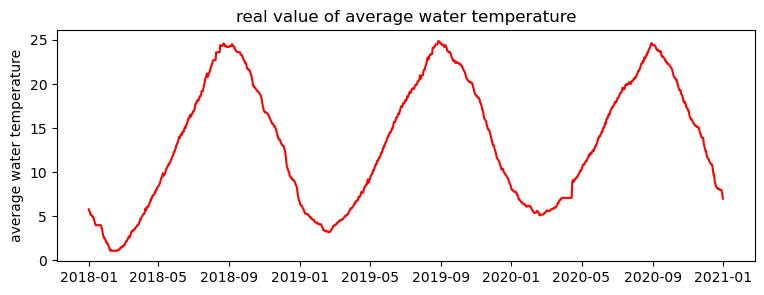

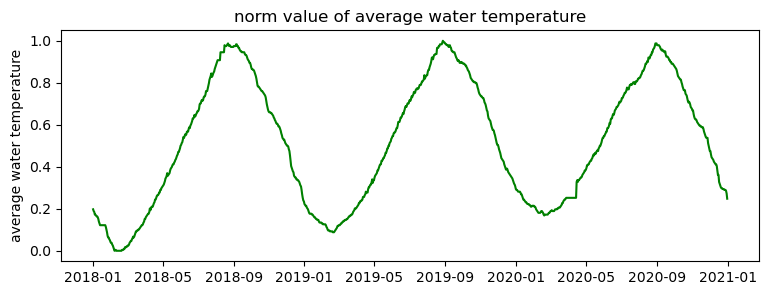

In [4]:
print("len(dataset_var) / len(label_) : ", len(dataset_var), '/', len(label_))
plt.figure(figsize=(9,3))
plt.plot(time_list, label_, 'r')
plt.ylabel('average water temperature')
plt.title('real value of average water temperature')
plt.show()

plt.figure(figsize=(9,3))
plt.plot(time_list, label_norm, 'g')
plt.ylabel('average water temperature')
plt.title('norm value of average water temperature')
plt.show()

## 2. seq_length에 따른 입출력 데이터 정의

In [5]:
#hyperparameter 1
sequence_length = 5
split = 880

In [6]:
def seq_data(x, y, sequence_length):
    x_seq, y_seq = [], []

    for i in range(len(x) - sequence_length):
        x_seq.append(x[i : i+sequence_length])
        y_seq.append(y[i+sequence_length])
    x_seq, y_seq = np.array(x_seq), np.array(y_seq).reshape([-1,1])
    return x_seq, y_seq

In [7]:
#확인하고 싶은 입력 데이터 종류를 바로 아래 코드 dataset_var에서 변화시키면 됩니다.(지금은 co2)
x_seq, y_seq = seq_data(dataset_var[:,-1], label_norm, sequence_length)
x_seq_ = x_seq.reshape(len(x_seq), sequence_length, -1)

#print(x_seq.shape) #(360,5,4)
x_train_seq = x_seq_[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq_[split:-1]
y_test_seq = y_seq[split:-1]

#print(type(x_seq)) #numpy.ndarray
#print(type(x_train_seq)) #numpy.ndarray

print("train data shape:", x_train_seq.shape, y_train_seq.shape)
print("target data shape:", x_test_seq.shape, y_test_seq.shape)

train data shape: (880, 5, 1) (880, 1)
target data shape: (210, 5, 1) (210, 1)


# 클래스 정의

In [8]:
class TimeMeanSquaredError:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, ts):
        diff = hs - ts
        square = diff ** 2
        loss = np.mean(square)
        self.cache = (diff, square, hs.shape)
        return loss

    def backward(self):
        diff, square, shape = self.cache
        batch_size = shape[0]
        dx = (diff * 2) / batch_size        
        return dx

In [9]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, H = x.shape
        #print("TimeAffine.forward:, x.shape:", x.shape)
        W, b = self.params #####
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        rout = out.reshape(N,T,-1)
        self.x = x
        #print("TimeAffine.forward, rout.shape:", rout.shape)
        return rout

    def backward(self, dout):
        x = self.x[:,-1,:]
        N, D = x.shape
        #print("x.shape", x.shape)
        W, b = self.params

        db = np.sum(dout, axis=0)
        dW = np.dot(x.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

In [10]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

In [11]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def set_state(self, h): #hidden state 설정
        self.h = h

    def reset_state(self): #hidden state 초기화
        self.h = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        #N : mini_batch_size, T : seq_length, D : input_size(입력데이터 종류)
        D, H = Wx.shape

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='float')

        hs = np.empty((N, T, H), dtype='float')
        self.layers = []

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        #print("TimeRNN, hs.shape:", hs.shape)
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        #print("TimeRNN.backward, dhs.shape", dhs.shape)

        N, D = dhs.shape
        D, H = Wx.shape
        T = seq_length
        dxs = np.empty((N, T, D), dtype='float')
        dh = dhs
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad

        self.dh = dh

        return dxs

In [12]:
class SimpleRnn:
    def __init__(self, seq_length, input_dim, hidden_size):
        T, D, H = seq_length, input_dim, hidden_size
        rn = np.random.randn

        # 초기 가중치 설정
        rnn_Wx = (rn(D,H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.ones(H).astype('f')
        affine_W = (rn(H, 1)) / np.sqrt(H).astype('f') # Output size is 1 (for predicting temperature)
        affine_b = np.zeros(1).astype('f')

        # Layers
        self.layers = [
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeMeanSquaredError() # Use Mean Squared Error for regression problems
        self.rnn_layer = self.layers[0]

        # Parameters and gradients
        self.params, self.grads = [], []

        for layer in self.layers: # TimeRNN을 모든 seq_length에 대해 돌림
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            hs = layer.forward(xs)
        #print("SimpleRNN.forward, hs.shape:", hs.shape)
        loss = self.loss_layer.forward(hs[:,-1,:], ts)
        return loss

    def backward(self):
        #dout = 
        dout = self.loss_layer.backward()
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        #print("SimpleRnn.backward, dout.shape:", dout.shape)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

    def predict(self, xs):
        for layer in self.layers:
            out = layer.forward(xs)
        ys = out[:,-1,:]
        return ys

In [13]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

# 모델 훈련

In [14]:
# 하이퍼파라미터 설정
batch_size = 5 #number of data in 1 batch
#input_dim = 1 #number of node in input layer(for 1 time-step) : co2, m2o, cfc12, methane
input_dim = 1
#hidden_size = 1 #number of node in hidden layer(for 1 time-step)
hidden_size = 1
seq_length = 5
lr = 1e-5 #lr decreasing
max_epoch = 10000

In [15]:
model = SimpleRnn(seq_length, input_dim, hidden_size)
optimizer = SGD(lr)
xss_train, tss_train = x_train_seq, y_train_seq

In [16]:
import time
#batch_size=N=1
data_size = len(xss_train)
max_iters = data_size // batch_size
time_list = []
train_loss_list = []

for epoch in (range(max_epoch)):
    total_loss = 0
    loss_count = 0
    start_time = time.time()
    for iters in range(max_iters):
        batch_x = xss_train[iters*batch_size:(iters+1)*batch_size]
        batch_x = batch_x.reshape(batch_size,seq_length,-1)
        #print("Train, batch_x.shape:", batch_x.shape)
        batch_t = tss_train[iters*batch_size:(iters+1)*batch_size]
        # 기울기 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # 평가
    avg_loss = total_loss / loss_count
    end_time = time.time()
    during_time= end_time - start_time
    time_list.append(during_time)
    train_loss_list.append(avg_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch} | time: {during_time} | loss: {avg_loss}")

print(((train_loss_list[0]-train_loss_list[-1])/train_loss_list[0])*100)

epoch: 0 | time: 0.02306199073791504 | loss: 0.15412911353179087
epoch: 100 | time: 0.015646934509277344 | loss: 0.15055692054136782
epoch: 200 | time: 0.015438079833984375 | loss: 0.14830668295988417
epoch: 300 | time: 0.015442132949829102 | loss: 0.1465956732243186
epoch: 400 | time: 0.016430139541625977 | loss: 0.145111108183397
epoch: 500 | time: 0.01546788215637207 | loss: 0.1437279459489633
epoch: 600 | time: 0.015442132949829102 | loss: 0.14239605474903974
epoch: 700 | time: 0.01551365852355957 | loss: 0.14109532624234908
epoch: 800 | time: 0.015521049499511719 | loss: 0.1398176059756336
epoch: 900 | time: 0.015585184097290039 | loss: 0.1385593899004469
epoch: 1000 | time: 0.015524864196777344 | loss: 0.1373192082682673
epoch: 1100 | time: 0.01557302474975586 | loss: 0.13609627026865
epoch: 1200 | time: 0.015475034713745117 | loss: 0.13489022474288867
epoch: 1300 | time: 0.015310049057006836 | loss: 0.1337006401424301
epoch: 1400 | time: 0.015776872634887695 | loss: 0.1325274944

# 하이퍼파라미터 최적화를 위한 무작위 탐색
optimization_trial = 100
results_train = {}

for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    batch_size = np.random.choice([5, 10])
    lr = 10 ** np.random.randint(-6, -4)
    max_epoch = np.random.choice([10000, 5000])
    # ================================================

    print("lr:", lr, "batch_size:", batch_size, "max_epoch:", max_epoch)

    # 모델을 재설정하여 새로운 하이퍼파라미터로 훈련 수행
    model = SimpleRnn(seq_length, input_dim, hidden_size)
    optimizer = SGD(lr)

    data_size = len(xss_train)
    max_iters = data_size // batch_size
    loss_list = []

    for epoch in range(max_epoch):
        total_loss = 0
        loss_count = 0
        start_time = time.time()

        for iters in range(max_iters):
            batch_x = xss_train[iters * batch_size:(iters + 1) * batch_size]
            batch_x = batch_x.reshape(batch_size, seq_length, -1)
            batch_t = tss_train[iters * batch_size:(iters + 1) * batch_size]

            loss = model.forward(batch_x, batch_t)
            model.backward()
            optimizer.update(model.params, model.grads)
            total_loss += loss
            loss_count += 1

        avg_loss = total_loss / loss_count
        loss_list.append(avg_loss)
        end_time = time.time()
        during_time = end_time - start_time

        if epoch % 5000 == 0:
            print(f"epoch: {epoch} | time: {during_time} | loss: {avg_loss}")

    # 결과 저장
    key = f"batch_size:{batch_size}, lr:{lr}, max_epoch:{max_epoch}"
    results_train[key] = ((loss_list[0]-loss_list[-1])/loss_list[0])*100  # 훈련 데이터의 평균 손실 저장

print(results_train)

rate of loss change 52.127805139108375
1st loss, last loss 0.15412911353179087 0.07378498956730381


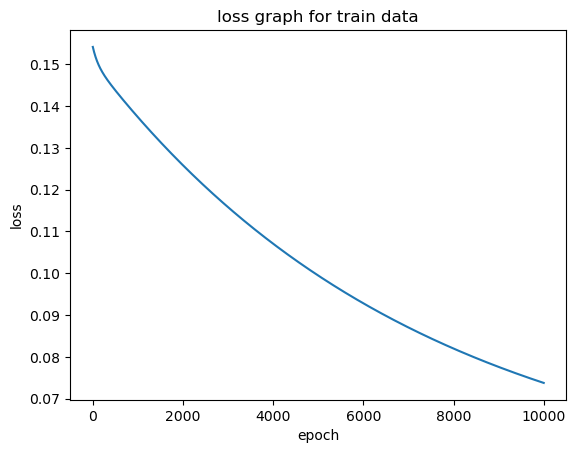

In [17]:
#loss graph for train data
print("rate of loss change", ((train_loss_list[0]-train_loss_list[-1])/train_loss_list[0])*100)
print("1st loss, last loss", train_loss_list[0], train_loss_list[-1])
plt.plot(train_loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss graph for train data')
plt.show()

# 예측

In [18]:
#predict for test data
xss_test, tss_test = x_test_seq, y_test_seq
data_size = len(xss_test)
max_iters = data_size // batch_size
test_pred_list = []
test_loss_list = []
for iters in range(max_iters):
    batch_x = xss_test[iters*batch_size:(iters+1)*batch_size]
    batch_x = batch_x.reshape(batch_size,seq_length,-1)
    batch_t = tss_test[iters*batch_size:(iters+1)*batch_size]
    test_pred = model.predict(batch_x).tolist()
    test_pred_list.append(test_pred)
    loss = model.forward(batch_x, batch_t)
    test_loss_list.append(loss)
    
test_pred_list = np.array(test_pred_list).flatten().tolist()


In [19]:
#predict for train data
xss_train, tss_train = x_train_seq, y_train_seq
data_size = len(xss_train)
max_iters = data_size // batch_size
train_pred_list = []
train_loss_lists = []
for iters in range(max_iters):
    batch_x = xss_train[iters*batch_size:(iters+1)*batch_size]
    batch_x = batch_x.reshape(batch_size,seq_length,-1)
    batch_t = tss_train[iters*batch_size:(iters+1)*batch_size]
    train_pred = model.predict(batch_x).tolist()
    train_pred_list.append(train_pred)
    loss = model.forward(batch_x, batch_t)
    train_loss_lists.append(loss)
    
train_pred_list = np.array(train_pred_list).flatten().tolist()

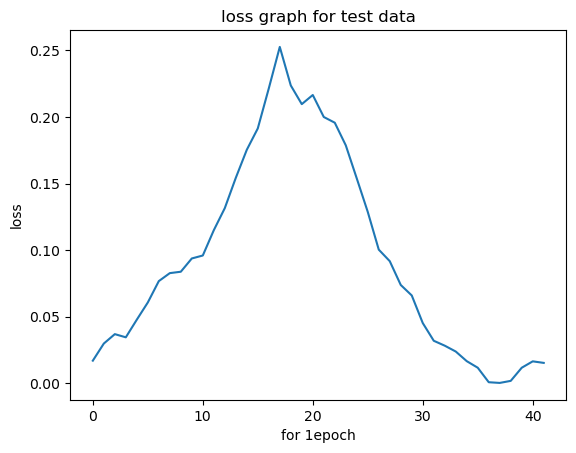

In [20]:
#loss graph for test data
plt.plot(test_loss_list)
plt.xlabel('for 1epoch')
plt.ylabel('loss')
plt.title('loss graph for test data')
plt.show()

In [21]:
#predict list for compare with label data
pred_list = label_norm[0:5].tolist()+train_pred_list + test_pred_list
print(len(pred_list)) #1095

1095


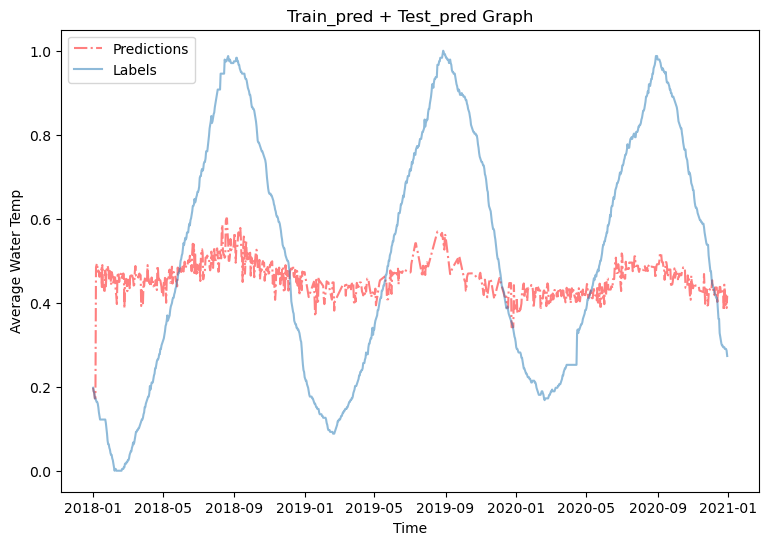

In [24]:
#만약 time_list의 dimension 오류가 발생한다면, 위에 있던 time 모듈에 의한 epoch를 time_list로 착각하여 그런것이니,
#time_list가 정의되어 있는 코드를 다시 한번 실행하고, 돌아와서 그래프를 그리면 그려질 것입니다.
plt.figure(figsize=(9,6))
plt.plot(time_list[:-1],pred_list,'-.r',label='Predictions', alpha=0.5)  # 예측값 그래프
plt.plot(time_list[:-1], label_norm[:-1], label='Labels', alpha=0.5)  # 실제값 그래프
plt.xlabel('Time')
plt.ylabel('Average Water Temp')
plt.title('Train_pred + Test_pred Graph')
plt.legend()
plt.show()

In [25]:
def MinMaxInverse(data, original_data):
    if isinstance(data, np.ndarray):
        numerator = data * (max(original_data) - min(original_data) + 1e-7)
        denominator = numerator + min(original_data)
    else:
        numerator = [x * (max(original_data) - min(original_data) + 1e-7) for x in data]
        denominator = [x + min(original_data) for x in numerator]
    return denominator

In [26]:
original_pred_list = MinMaxInverse(pred_list, label_)

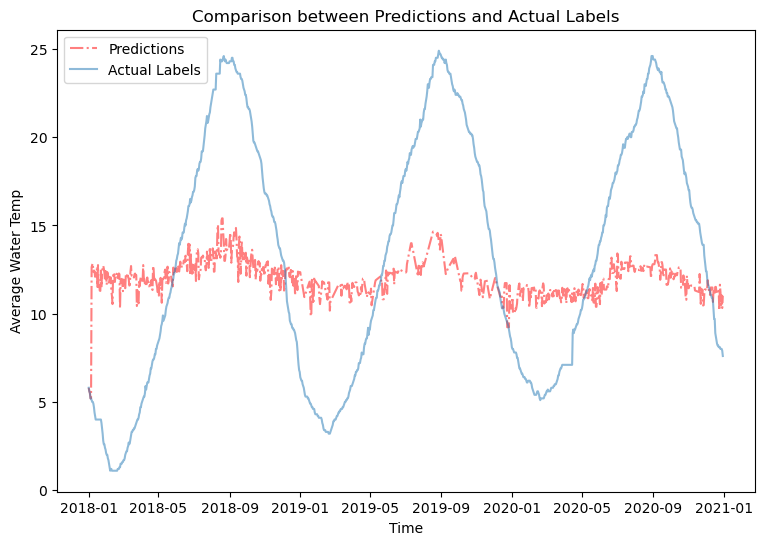

In [27]:
plt.figure(figsize=(9,6))
plt.plot(time_list[:-1], original_pred_list, '-.r', label='Predictions', alpha=0.5)  # 예측값 그래프
plt.plot(time_list[:-1], label_[:-1], label='Actual Labels', alpha=0.5)  # 실제값 그래프
plt.xlabel('Time')
plt.ylabel('Average Water Temp')
plt.title('Comparison between Predictions and Actual Labels')
plt.legend()
plt.show()

# 정확도

In [28]:
# MAE, MSE, R-squared 값 계산 및 저장
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
val_pred_list = pred_list
mae = mean_absolute_error(label_norm[:-1], val_pred_list)
mse = mean_squared_error(label_norm[:-1], val_pred_list)
#r_squared = r2_score(label_norm[:-1], val_pred_list)

# 결과 출력
print(f"MAE: {mae}")
print(f"MSE: {mse}")

#for variable, r_squared in r_squared_values.items():
#    print(f"Variable: {variable} - R-squared: {r_squared}")


MAE: 0.24241257922483364
MSE: 0.07729510852105685
